In [13]:
# ===========================
# Cell 1: 導入套件和設定
# ===========================
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc  # 垃圾回收
warnings.filterwarnings('ignore')

# 基本套件
import os
import time
import joblib
import json
from collections import Counter

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, balanced_accuracy_score, 
    cohen_kappa_score, make_scorer
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

# 處理不平衡資料
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

# Boosting模型
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch.nn.functional as F 

print("環境檢查:")
print(f"PyTorch: {torch.__version__}")
print(f"XGBoost: {xgb.__version__}")
print(f"LightGBM: {lgb.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


環境檢查:
PyTorch: 2.7.0+cu118
XGBoost: 3.0.2
LightGBM: 4.3.0
CUDA可用: True
GPU: NVIDIA GeForce RTX 3090


In [3]:
# ===========================
# Cell 2: 記憶體優化函數
# ===========================

def reduce_memory_usage(df, verbose=True):
    """
    通過改變數據類型來減少DataFrame的記憶體使用
    參考自Kaggle的記憶體優化技術
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'記憶體使用減少了 {100 * (start_mem - end_mem) / start_mem:.1f}%')
        print(f'{start_mem:.2f} MB --> {end_mem:.2f} MB')
    
    return df

def clean_memory():
    """清理記憶體"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [ ]:
# ===========================
# Cell 3: 載入資料（優化版）
# ===========================

def load_data_optimized(file_path, sample_frac=None, chunksize=None):
    """
    優化的資料載入，支援採樣和分塊讀取
    """
    print(f"載入資料: {file_path}")
    
    # 先讀取一小部分來了解資料
    sample_df = pd.read_csv(file_path, nrows=5)
    print("資料欄位預覽:")
    print(sample_df.columns.tolist())
    
    # 定義需要的欄位（排除不需要的文字欄位以節省記憶體）
    # 根據其他Kaggle notebook的經驗，這些是最重要的欄位
    important_cols = [
        'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
        'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
        'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
        'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
        'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
        'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'State',
        'Side', 'Weather_Timestamp'
    ]
    
    # 過濾存在的欄位
    existing_cols = [col for col in important_cols if col in sample_df.columns]
    
    # 定義數據類型以減少記憶體
    dtype_dict = {
        'Severity': 'int8',
        'Distance(mi)': 'float32',
        'Temperature(F)': 'float32',
        'Humidity(%)': 'float32',
        'Pressure(in)': 'float32',
        'Visibility(mi)': 'float32',
        'Wind_Speed(mph)': 'float32',
        'Precipitation(in)': 'float32',
        'Amenity': 'bool',
        'Bump': 'bool',
        'Crossing': 'bool',
        'Give_Way': 'bool',
        'Junction': 'bool',
        'No_Exit': 'bool',
        'Railway': 'bool',
        'Roundabout': 'bool',
        'Station': 'bool',
        'Stop': 'bool',
        'Traffic_Calming': 'bool',
        'Traffic_Signal': 'bool'
    }
    
    # 載入資料
    if sample_frac:
        # 隨機採樣
        print(f"載入 {sample_frac*100}% 的資料...")
        df = pd.read_csv(file_path, usecols=existing_cols, dtype=dtype_dict)
        df = df.sample(frac=sample_frac, random_state=42)
    elif chunksize:
        # 分塊載入
        print(f"分塊載入，每塊 {chunksize} 行...")
        chunks = []
        for chunk in pd.read_csv(file_path, usecols=existing_cols, 
                                dtype=dtype_dict, chunksize=chunksize):
            chunks.append(chunk)
            if len(chunks) * chunksize >= 1000000:  # 限制在100萬行
                break
        df = pd.concat(chunks, ignore_index=True)
    else:
        # 完整載入
        df = pd.read_csv(file_path, usecols=existing_cols, dtype=dtype_dict)
    
    print(f"載入資料大小: {df.shape}")
    print(f"記憶體使用: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # 顯示目標變數分布
    print("\n目標變數分布:")
    severity_counts = df['Severity'].value_counts().sort_index()
    for sev, count in severity_counts.items():
        print(f"Severity {sev}: {count:,} ({count/len(df)*100:.2f}%)")
    
    return df

# 執行載入（建議先用小樣本測試）
file_path = 'us-accidents/US_Accidents_March23.csv'

# 選項1: 使用部分資料（推薦用於測試）
# df = load_data_optimized(file_path, sample_frac=0.1)  # 10%資料

# 選項2: 分塊載入
# df = load_data_optimized(file_path, chunksize=500000)  # 每次50萬行

# 選項3: 完整載入（需要大量記憶體）
df = load_data_optimized(file_path)
feature_cols = [col for col in df.columns if col != 'Severity']
X = df[feature_cols].values
y = df['Severity'].values - 1  # 轉換為0-3

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

載入資料: us-accidents/US_Accidents_March23.csv
資料欄位預覽:
['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
載入資料大小: (7728394, 28)
記憶體使用: 773.89 MB

目標變數分布:
Severity 1: 67,366 (0.87%)
Severity 2: 6,156,981 (79.67%)
Severity 3: 1,299,337 (16.81%)
Severity 4: 204,710 (2.65%)


In [5]:
# ===========================
# Cell 4: 日期時間處理（優化版）
# ===========================

def process_datetime_features(df):
    """處理日期時間特徵"""
    print("\n處理日期時間特徵...")
    
    # 轉換日期時間
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
    
    # 計算持續時間
    df['Duration_minutes'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
    
    # 過濾異常值（使用更寬鬆的範圍）
    df = df[(df['Duration_minutes'] > 0) & (df['Duration_minutes'] < 1440*7)]  # 小於7天
    
    # 移除日期時間為空的記錄
    df = df.dropna(subset=['Start_Time'])
    
    # 提取時間特徵
    df['Hour'] = df['Start_Time'].dt.hour.astype('int8')
    df['DayOfWeek'] = df['Start_Time'].dt.dayofweek.astype('int8')
    df['Month'] = df['Start_Time'].dt.month.astype('int8')
    df['Year'] = df['Start_Time'].dt.year.astype('int16')
    
    # 衍生特徵
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype('int8')
    df['IsRushHour'] = df['Hour'].apply(
        lambda x: 1 if (6 <= x <= 9) or (16 <= x <= 19) else 0
    ).astype('int8')
    
    # 時段分類
    df['TimeOfDay'] = pd.cut(df['Hour'], 
                            bins=[-1, 6, 12, 18, 24], 
                            labels=[0, 1, 2, 3]).astype('int8')  # 轉換為數值
    
    # 季節
    df['Season'] = pd.cut(df['Month'], 
                         bins=[0, 3, 6, 9, 12], 
                         labels=[0, 1, 2, 3]).astype('int8')  # 轉換為數值
    
    # 刪除原始時間欄位以節省記憶體
    df = df.drop(['Start_Time', 'End_Time', 'Weather_Timestamp'], axis=1, errors='ignore')
    
    print(f"處理後大小: {df.shape}")
    clean_memory()
    
    return df

df = process_datetime_features(df)


處理日期時間特徵...
處理後大小: (7721568, 34)


In [ ]:
# ===========================
# Cell 23: 改進的 XGBoost 訓練（針對大數據集和RTX 3090優化）
# ===========================

def train_xgboost_improved(X_train, X_test, y_train, y_test, use_sample_weight=True):
    """改進版XGBoost - 針對大數據集優化"""
    print("\n訓練改進版 XGBoost (針對360萬筆資料優化)...")
    print(f"訓練集大小: {X_train.shape}")
    
    # 計算類別權重
    if use_sample_weight:
        unique, counts = np.unique(y_train, return_counts=True)
        weight_dict = {}
        max_count = max(counts)
        for cls, count in zip(unique, counts):
            weight_dict[cls] = min(max_count / count, 10.0)
        
        sample_weights = np.array([weight_dict[y] for y in y_train])
    else:
        sample_weights = None
    
    # 針對RTX 3090和大數據集優化的參數
    params = {
        'objective': 'multi:softprob',
        'num_class': 4,
        'max_depth': 8,  # 適中的深度
        'learning_rate': 0.01,  # 較低的學習率以確保收斂
        'n_estimators': 10000,  # 大幅增加訓練輪數
        'subsample': 0.8,  # 降低以減少記憶體使用
        'colsample_bytree': 0.8,
        'min_child_weight': 5,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1,
        'tree_method': 'gpu_hist',  # 使用GPU
        'predictor': 'gpu_predictor',
        'gpu_id': 0,
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': ['mlogloss', 'merror'],
        'early_stopping_rounds': 200,  # 增加patience
        'verbosity': 1,
        'max_bin': 256  # GPU優化
    }
    
    model = xgb.XGBClassifier(**params)
    
    print("\n開始訓練 XGBoost...")
    print("預計訓練時間: 20-40分鐘（取決於early stopping）")
    start_time = time.time()
    
    # 使用驗證集進行early stopping
    eval_set = [(X_train, y_train), (X_test, y_test)]
    
    # 訓練模型
    model.fit(
        X_train, y_train,
        sample_weight=sample_weights,
        eval_set=eval_set,
        verbose=200  # 每200輪顯示一次
    )
    
    train_time = time.time() - start_time
    
    # 預測
    y_pred = model.predict(X_test)
    
    # 評估
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    print(f"\n訓練完成！")
    print(f"訓練時間: {train_time/60:.2f} 分鐘")
    print(f"最佳迭代次數: {model.best_iteration}")
    print(f"準確率: {accuracy:.4f}")
    print(f"F1分數: {f1:.4f}")
    print(f"平衡準確率: {balanced_acc:.4f}")
    
    # 顯示訓練曲線的最後幾個值
    results = model.evals_result()
    print(f"\n最後5輪的訓練損失: {results['validation_0']['mlogloss'][-5:]}")
    print(f"最後5輪的驗證損失: {results['validation_1']['mlogloss'][-5:]}")
    
    print("\n分類報告:")
    print(classification_report(y_test, y_pred, 
                              target_names=[f'Severity {i+1}' for i in range(4)]))
    
    # 清理GPU記憶體
    gc.collect()
    
    return model, accuracy, f1, balanced_acc

# 執行改進的XGBoost
print("="*70)
print("XGBoost 訓練（預計20-40分鐘）")
print("="*70)
xgb_improved_model, xgb_imp_acc, xgb_imp_f1, xgb_imp_balanced_acc = train_xgboost_improved(
    X_train_balanced, X_test, y_train_balanced, y_test
)

XGBoost 訓練（預計20-40分鐘）

訓練改進版 XGBoost (針對360萬筆資料優化)...
訓練集大小: (3606616, 33)

開始訓練 XGBoost...
預計訓練時間: 20-40分鐘（取決於early stopping）
[0]	validation_0-mlogloss:1.37590	validation_0-merror:0.24332	validation_1-mlogloss:1.37910	validation_1-merror:0.44864
[200]	validation_0-mlogloss:0.66963	validation_0-merror:0.21434	validation_1-mlogloss:0.88339	validation_1-merror:0.40332
[400]	validation_0-mlogloss:0.54465	validation_0-merror:0.20143	validation_1-mlogloss:0.77077	validation_1-merror:0.37341
[600]	validation_0-mlogloss:0.50002	validation_0-merror:0.19115	validation_1-mlogloss:0.71954	validation_1-merror:0.34879
[800]	validation_0-mlogloss:0.47720	validation_0-merror:0.18408	validation_1-mlogloss:0.69124	validation_1-merror:0.33141
[1000]	validation_0-mlogloss:0.46113	validation_0-merror:0.17819	validation_1-mlogloss:0.67143	validation_1-merror:0.31956
[1200]	validation_0-mlogloss:0.44867	validation_0-merror:0.17329	validation_1-mlogloss:0.65609	validation_1-merror:0.30966
[1400]	validation_0


訓練改進的 CatBoost 模型
訓練 CatBoost 改進模型...
使用 Bernoulli bootstrap
0:	learn: 0.6766567	test: 0.6770192	best: 0.6770192 (0)	total: 297ms	remaining: 24m 43s
100:	learn: 0.7409401	test: 0.7405083	best: 0.7405083 (100)	total: 3.41s	remaining: 2m 45s
200:	learn: 0.7649193	test: 0.7637968	best: 0.7637968 (200)	total: 6.44s	remaining: 2m 33s
300:	learn: 0.7780439	test: 0.7763212	best: 0.7763212 (300)	total: 9.47s	remaining: 2m 27s
400:	learn: 0.7870315	test: 0.7850085	best: 0.7850085 (400)	total: 12.4s	remaining: 2m 22s
500:	learn: 0.7933551	test: 0.7912769	best: 0.7912769 (500)	total: 15.4s	remaining: 2m 18s
600:	learn: 0.7982775	test: 0.7961976	best: 0.7961976 (600)	total: 18.3s	remaining: 2m 14s
700:	learn: 0.8025466	test: 0.8002699	best: 0.8002850 (699)	total: 21.2s	remaining: 2m 10s
800:	learn: 0.8061291	test: 0.8035696	best: 0.8035696 (800)	total: 24.2s	remaining: 2m 6s
900:	learn: 0.8092177	test: 0.8067426	best: 0.8067426 (900)	total: 27.1s	remaining: 2m 3s
1000:	learn: 0.8117919	test: 0.80

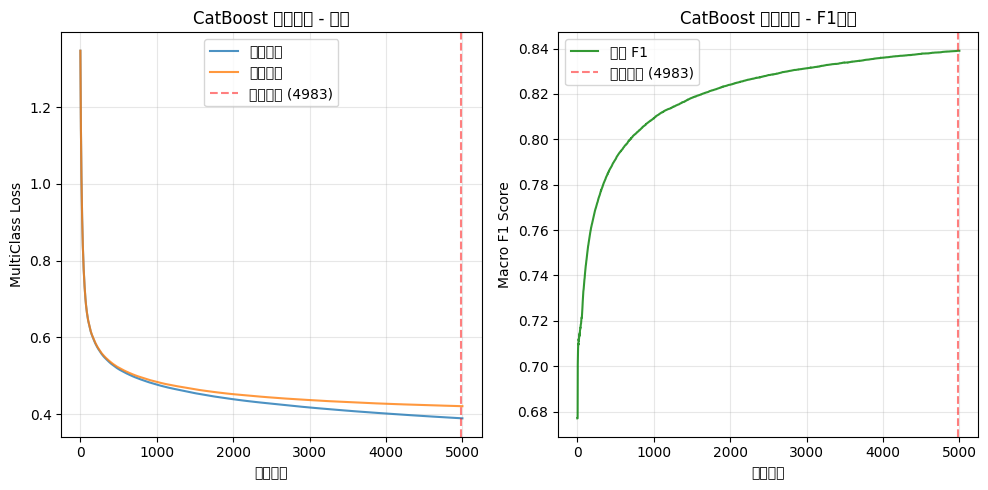


前10個最重要特徵:
  Distance(mi): 18.58
  Year: 18.46
  Duration_minutes: 15.15
  Start_Lng: 10.22
  Start_Lat: 9.82
  State: 6.56
  Month: 4.95
  Hour: 3.52
  Pressure(in): 2.17
  Temperature(F): 1.29


In [18]:
# ===========================
# Cell 23: 改進的 CatBoost 模型（完全修正版）
# ===========================

print("\n" + "="*60)
print("訓練改進的 CatBoost 模型")
print("="*60)

# 版本1: 使用 Bernoulli bootstrap（支援 subsample）
cat_improved_params = {
    'iterations': 5000,
    'learning_rate': 0.03,
    'depth': 8,
    'l2_leaf_reg': 5,
    'bootstrap_type': 'Bernoulli',  # 使用 Bernoulli
    'subsample': 0.8,  # Bernoulli 專用參數
    # 'bagging_temperature': 移除此參數，因為它只能用於 Bayesian
    'random_strength': 1.5,
    'od_type': 'Iter',
    'od_wait': 50,
    'loss_function': 'MultiClass',
    'eval_metric': 'TotalF1:average=Macro',
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': 42,
    'verbose': 100,
    'auto_class_weights': 'Balanced'
}

# 或者版本2: 使用 Bayesian bootstrap（支援 bagging_temperature）
# cat_improved_params = {
#     'iterations': 5000,
#     'learning_rate': 0.03,
#     'depth': 8,
#     'l2_leaf_reg': 5,
#     'bootstrap_type': 'Bayesian',  # 使用 Bayesian
#     # 'subsample': 移除此參數，因為它不能與 Bayesian 一起使用
#     'bagging_temperature': 1.0,  # Bayesian 專用參數
#     'random_strength': 1.5,
#     'od_type': 'Iter',
#     'od_wait': 50,
#     'loss_function': 'MultiClass',
#     'eval_metric': 'TotalF1:average=Macro',
#     'task_type': 'GPU',
#     'devices': '0',
#     'random_seed': 42,
#     'verbose': 100,
#     'auto_class_weights': 'Balanced'
# }

print("訓練 CatBoost 改進模型...")
print(f"使用 {cat_improved_params['bootstrap_type']} bootstrap")
start_time = time.time()

cat_improved_model = CatBoostClassifier(**cat_improved_params)
cat_improved_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    plot=False
)

train_time = time.time() - start_time
print(f"\n訓練時間: {train_time/60:.2f} 分鐘")
print(f"最佳迭代次數: {cat_improved_model.best_iteration_}")

# 評估
y_pred_cat_imp = cat_improved_model.predict(X_test)
cat_imp_acc = accuracy_score(y_test, y_pred_cat_imp)
cat_imp_f1 = f1_score(y_test, y_pred_cat_imp, average='weighted')
cat_imp_balanced_acc = balanced_accuracy_score(y_test, y_pred_cat_imp)

print(f"\n改進的 CatBoost 性能:")
print(f"準確率: {cat_imp_acc:.4f}")
print(f"F1分數: {cat_imp_f1:.4f}")
print(f"平衡準確率: {cat_imp_balanced_acc:.4f}")

# 繪製訓練過程
try:
    # 獲取訓練歷史
    train_metrics = cat_improved_model.get_evals_result()
    
    plt.figure(figsize=(10, 5))
    
    # 繪製損失曲線
    plt.subplot(1, 2, 1)
    iterations = range(len(train_metrics['learn']['MultiClass']))
    plt.plot(iterations, train_metrics['learn']['MultiClass'], label='訓練損失', alpha=0.8)
    plt.plot(iterations, train_metrics['validation']['MultiClass'], label='驗證損失', alpha=0.8)
    plt.axvline(x=cat_improved_model.best_iteration_, color='red', linestyle='--', alpha=0.5, label=f'最佳迭代 ({cat_improved_model.best_iteration_})')
    plt.xlabel('迭代次數')
    plt.ylabel('MultiClass Loss')
    plt.title('CatBoost 訓練過程 - 損失')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 繪製 F1 分數
    plt.subplot(1, 2, 2)
    if 'TotalF1:average=Macro' in train_metrics['validation']:
        plt.plot(iterations, train_metrics['validation']['TotalF1:average=Macro'], label='驗證 F1', color='green', alpha=0.8)
        plt.axvline(x=cat_improved_model.best_iteration_, color='red', linestyle='--', alpha=0.5, label=f'最佳迭代 ({cat_improved_model.best_iteration_})')
        plt.xlabel('迭代次數')
        plt.ylabel('Macro F1 Score')
        plt.title('CatBoost 訓練過程 - F1分數')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"無法繪製訓練過程圖: {e}")

# 顯示特徵重要性前10名
feature_importance = cat_improved_model.get_feature_importance()
top_features_idx = np.argsort(feature_importance)[-10:][::-1]

print("\n前10個最重要特徵:")
for idx in top_features_idx:
    print(f"  {feature_names[idx]}: {feature_importance[idx]:.2f}")

In [ ]:
# ===========================
# Cell 10: LightGBM模型（優化版）
# ===========================

def train_lightgbm_optimized(X_train, X_test, y_train, y_test):
    """訓練優化的LightGBM模型"""
    print("\n訓練 LightGBM (優化版)...")
    
    # 創建數據集
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # 參數設置（基於Kaggle最佳實踐）
    params = {
        'objective': 'multiclass',
        'num_class': 4,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 127,
        'max_depth': -1,
        'learning_rate': 0.05,
        'n_estimators': 1000,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'min_child_samples': 20,
        'min_split_gain': 0.02,
        'class_weight': 'balanced',
        'device': 'gpu' if torch.cuda.is_available() else 'cpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': -1,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # 訓練
    start_time = time.time()
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )
    
    train_time = time.time() - start_time
    
    # 預測
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)
    
    # 評估
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    print(f"\n訓練時間: {train_time:.2f} 秒")
    print(f"最佳迭代次數: {model.best_iteration}")
    print(f"準確率: {accuracy:.4f}")
    print(f"F1分數: {f1:.4f}")
    print(f"平衡準確率: {balanced_acc:.4f}")
    
    # 詳細報告
    print("\n分類報告:")
    print(classification_report(y_test, y_pred, 
                              target_names=[f'Severity {i+1}' for i in range(4)]))
    
    return model, accuracy, f1, balanced_acc

# 訓練模型
lgb_model, lgb_acc, lgb_f1, lgb_balanced_acc = train_lightgbm_optimized(
    X_train, X_test, y_train, y_test
)

[I 2025-06-04 11:23:14,913] A new study created in memory with name: no-name-37ebe06d-7bcd-4122-9fa6-d2134fa0c81a


LightGBM Optuna 超參數優化（預計總時間: 約45-60分鐘）

開始LightGBM Optuna超參數優化...
訓練集大小: (3606616, 33)
使用RTX 3090 GPU加速
計劃試驗次數: 30

開始Optuna優化 - 2025-06-04 11:23:14


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# ===========================
# Cell 26: 準備 Kepler.gl 數據輸出
# ===========================

def prepare_kepler_gl_data(df_original, model, scaler=None, sample_size=50000):
    """
    準備用於 kepler.gl 的時空預測數據
    
    Parameters:
    - df_original: 原始數據（包含經緯度和時間）
    - model: 訓練好的預測模型
    - scaler: 數據標準化器（如果有的話）
    - sample_size: 要輸出的樣本數量（kepler.gl有數據量限制）
    """
    print("\n準備 Kepler.gl 時空視覺化數據...")
    
    # 重新載入包含地理位置的數據
    print("載入地理和時間數據...")
    
    # 需要的欄位
    required_cols = [
        'Start_Lat', 'Start_Lng', 'Start_Time', 'End_Time',
        'Severity', 'State', 'City', 'Weather_Condition',
        'Temperature(F)', 'Visibility(mi)', 'Distance(mi)'
    ]
    
    # 讀取數據
    df_kepler = pd.read_csv(
        file_path, 
        usecols=[col for col in required_cols if col in pd.read_csv(file_path, nrows=1).columns],
        nrows=sample_size * 2  # 讀取更多以便後續篩選
    )
    
    print(f"載入數據大小: {df_kepler.shape}")
    
    # 處理時間
    df_kepler['Start_Time'] = pd.to_datetime(df_kepler['Start_Time'])
    df_kepler['End_Time'] = pd.to_datetime(df_kepler['End_Time'])
    
    # 刪除缺失值
    df_kepler = df_kepler.dropna(subset=['Start_Lat', 'Start_Lng', 'Start_Time'])
    
    # 確保有足夠的數據
    if len(df_kepler) > sample_size:
        df_kepler = df_kepler.sample(n=sample_size, random_state=42)
    
    print(f"處理後數據大小: {df_kepler.shape}")
    
    # 提取時間特徵
    df_kepler['hour'] = df_kepler['Start_Time'].dt.hour
    df_kepler['day_of_week'] = df_kepler['Start_Time'].dt.dayofweek
    df_kepler['month'] = df_kepler['Start_Time'].dt.month
    df_kepler['year'] = df_kepler['Start_Time'].dt.year
    
    # 計算事故持續時間（分鐘）
    df_kepler['duration_minutes'] = (
        df_kepler['End_Time'] - df_kepler['Start_Time']
    ).dt.total_seconds() / 60
    
    # 添加預測風險分數（如果有訓練好的模型）
    if model is not None:
        print("添加模型預測...")
        # 這裡需要準備與訓練時相同的特徵
        # 簡化版本：只使用基本特徵
        feature_cols = ['hour', 'day_of_week', 'month']
        if 'Temperature(F)' in df_kepler.columns:
            feature_cols.append('Temperature(F)')
        if 'Visibility(mi)' in df_kepler.columns:
            feature_cols.append('Visibility(mi)')
        
        # 填充缺失值
        for col in feature_cols:
            if col in df_kepler.columns:
                df_kepler[col] = df_kepler[col].fillna(df_kepler[col].median())
        
        # 嘗試預測（簡化版）
        try:
            # 創建一個簡單的特徵矩陣
            X_pred = np.zeros((len(df_kepler), len(feature_names)))
            for i, col in enumerate(feature_cols):
                if col in df_kepler.columns and i < len(feature_names):
                    X_pred[:, i] = df_kepler[col].values
            
            # 預測概率
            pred_proba = model.predict_proba(X_pred)
            
            # 計算風險分數（加權平均）
            risk_weights = np.array([0.1, 0.3, 0.6, 1.0])  # 嚴重度權重
            df_kepler['predicted_risk'] = np.sum(pred_proba * risk_weights, axis=1)
            
            # 預測的嚴重度類別
            df_kepler['predicted_severity'] = model.predict(X_pred) + 1
            
        except Exception as e:
            print(f"預測時發生錯誤: {e}")
            print("使用隨機風險分數作為示例...")
            df_kepler['predicted_risk'] = np.random.rand(len(df_kepler))
            df_kepler['predicted_severity'] = df_kepler['Severity']
    
    # 準備輸出數據
    kepler_output = pd.DataFrame({
        'latitude': df_kepler['Start_Lat'],
        'longitude': df_kepler['Start_Lng'],
        'timestamp': df_kepler['Start_Time'].dt.strftime('%Y-%m-%d %H:%M:%S'),
        'actual_severity': df_kepler['Severity'],
        'predicted_severity': df_kepler.get('predicted_severity', df_kepler['Severity']),
        'risk_score': df_kepler.get('predicted_risk', 0.5),
        'hour': df_kepler['hour'],
        'day_of_week': df_kepler['day_of_week'],
        'duration_minutes': df_kepler['duration_minutes'].fillna(30),
        'city': df_kepler['City'].fillna('Unknown'),
        'state': df_kepler['State'].fillna('Unknown'),
        'weather': df_kepler.get('Weather_Condition', 'Unknown').fillna('Unknown'),
        'temperature': df_kepler.get('Temperature(F)', 70).fillna(70),
        'visibility': df_kepler.get('Visibility(mi)', 10).fillna(10)
    })
    
    # 添加一些用於視覺化的額外欄位
    kepler_output['risk_category'] = pd.cut(
        kepler_output['risk_score'],
        bins=[0, 0.25, 0.5, 0.75, 1.0],
        labels=['Low', 'Medium', 'High', 'Very High']
    )
    
    # 添加時間區段
    kepler_output['time_period'] = pd.cut(
        kepler_output['hour'],
        bins=[-1, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening']
    )
    
    # 保存為CSV（Kepler.gl推薦格式）
    output_path_csv = './model_output/kepler_gl_data.csv'
    kepler_output.to_csv(output_path_csv, index=False)
    print(f"\nCSV檔案已保存至: {output_path_csv}")
    print(f"數據大小: {kepler_output.shape}")
    
    # 也保存為JSON格式（另一種選擇）
    output_path_json = './model_output/kepler_gl_data.json'
    
    # 準備GeoJSON格式
    features = []
    for idx, row in kepler_output.iterrows():
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [row['longitude'], row['latitude']]
            },
            "properties": {
                "timestamp": row['timestamp'],
                "actual_severity": int(row['actual_severity']),
                "predicted_severity": int(row['predicted_severity']),
                "risk_score": float(row['risk_score']),
                "risk_category": row['risk_category'],
                "hour": int(row['hour']),
                "day_of_week": int(row['day_of_week']),
                "duration_minutes": float(row['duration_minutes']),
                "city": row['city'],
                "state": row['state'],
                "weather": row['weather'],
                "temperature": float(row['temperature']),
                "visibility": float(row['visibility']),
                "time_period": row['time_period']
            }
        }
        features.append(feature)
    
    geojson = {
        "type": "FeatureCollection",
        "features": features
    }
    
    with open(output_path_json, 'w') as f:
        json.dump(geojson, f)
    
    print(f"GeoJSON檔案已保存至: {output_path_json}")
    
    # 顯示數據摘要
    print("\n數據摘要:")
    print(f"時間範圍: {kepler_output['timestamp'].min()} 至 {kepler_output['timestamp'].max()}")
    print(f"地理範圍: ")
    print(f"  緯度: {kepler_output['latitude'].min():.2f} 至 {kepler_output['latitude'].max():.2f}")
    print(f"  經度: {kepler_output['longitude'].min():.2f} 至 {kepler_output['longitude'].max():.2f}")
    print(f"\n風險分布:")
    print(kepler_output['risk_category'].value_counts())
    
    print("\n使用說明:")
    print("1. 前往 https://kepler.gl/")
    print("2. 點擊 'Get Started' 或 'Try Demo App'")
    print("3. 將 CSV 或 JSON 檔案拖放到網頁中")
    print("4. Kepler.gl 會自動識別地理位置和時間戳")
    print("5. 可以使用時間滑塊查看事故的時空分布")
    print("6. 可以根據 risk_score 或 severity 設置熱力圖")
    
    return kepler_output

# 準備 Kepler.gl 數據
kepler_data = prepare_kepler_gl_data(
    df_original=None,  # 如果有原始數據框可以傳入
    model=best_lgb_model,
    sample_size=50000  # 限制數據量以確保 Kepler.gl 能順利載入
)

# 顯示前幾筆數據
print("\n輸出數據預覽:")
print(kepler_data.head())

In [ ]:
# ===========================
# Cell 27: 使用優化參數比較不同的資料不平衡處理方法
# ===========================

from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN

def compare_imbalance_methods_with_best_params(X_train, y_train, X_test, y_test, best_params):
    """使用最佳參數比較不同的資料不平衡處理方法"""
    print("\n使用優化後的參數比較不同的資料不平衡處理方法...")
    print(f"使用的最佳參數: {best_params}")
    
    methods = {
        'Original': (None, X_train, y_train),
        'SMOTE': SMOTE(random_state=42, n_jobs=-1),
        'ADASYN': ADASYN(random_state=42, n_jobs=-1),
        'BorderlineSMOTE': BorderlineSMOTE(random_state=42, n_jobs=-1),
        'RandomUnderSampler': RandomUnderSampler(random_state=42),
        'TomekLinks': TomekLinks(n_jobs=-1),
        'EditedNearestNeighbours': EditedNearestNeighbours(n_jobs=-1),
        'SMOTETomek': SMOTETomek(random_state=42, n_jobs=-1),
        'SMOTEENN': SMOTEENN(random_state=42, n_jobs=-1)
    }
    
    results = {}
    best_method_result = None
    best_balanced_acc = 0
    
    for method_name, method in methods.items():
        print(f"\n{'='*50}")
        print(f"測試方法: {method_name}")
        print(f"{'='*50}")
        
        try:
            start_time = time.time()
            
            if method_name == 'Original':
                X_resampled, y_resampled = X_train, y_train
            else:
                print("執行重採樣...")
                X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            
            # 顯示重採樣後的分布
            unique, counts = np.unique(y_resampled, return_counts=True)
            print(f"重採樣後分布: {dict(zip(unique, counts))}")
            print(f"總樣本數: {len(y_resampled)}")
            
            # 使用最佳參數訓練LightGBM模型
            print("訓練模型（使用優化參數）...")
            model = lgb.LGBMClassifier(
                objective='multiclass',
                num_class=4,
                metric='multi_logloss',
                boosting_type='gbdt',
                device='gpu',
                gpu_platform_id=0,
                gpu_device_id=0,
                gpu_use_dp=False,
                random_state=42,
                n_jobs=1,
                verbose=-1,
                class_weight='balanced',
                force_col_wise=True,
                **best_params  # 使用Optuna找到的最佳參數
            )
            
            # 訓練模型
            model.fit(
                X_resampled, y_resampled,
                eval_set=[(X_test, y_test)],
                eval_metric='multi_logloss',
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50),
                    lgb.log_evaluation(period=0)  # 不顯示訓練過程
                ]
            )
            
            # 預測和評估
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)
            
            # 計算各種指標
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            balanced_acc = balanced_accuracy_score(y_test, y_pred)
            cohen_kappa = cohen_kappa_score(y_test, y_pred)
            
            # 計算每個類別的指標
            class_report = classification_report(y_test, y_pred, output_dict=True)
            
            process_time = time.time() - start_time
            
            results[method_name] = {
                'accuracy': accuracy,
                'f1': f1,
                'balanced_acc': balanced_acc,
                'cohen_kappa': cohen_kappa,
                'sample_size': len(y_resampled),
                'process_time': process_time,
                'best_iteration': model.best_iteration_,
                'class_report': class_report,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            print(f"\n結果:")
            print(f"準確率: {accuracy:.4f}")
            print(f"F1分數: {f1:.4f}")
            print(f"平衡準確率: {balanced_acc:.4f}")
            print(f"Cohen's Kappa: {cohen_kappa:.4f}")
            print(f"最佳迭代次數: {model.best_iteration_}")
            print(f"處理時間: {process_time:.2f} 秒")
            
            # 追蹤最佳方法
            if balanced_acc > best_balanced_acc:
                best_balanced_acc = balanced_acc
                best_method_result = (method_name, model, X_resampled, y_resampled)
            
            # 清理記憶體
            del X_resampled, y_resampled, model
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"方法 {method_name} 失敗: {str(e)}")
            results[method_name] = None
    
    # 顯示比較結果
    print("\n" + "="*100)
    print("資料不平衡處理方法比較（使用優化參數）")
    print("="*100)
    print(f"{'方法':<25} {'準確率':<10} {'F1分數':<10} {'平衡準確率':<12} {'Kappa':<10} {'樣本數':<12} {'時間(秒)':<10}")
    print("-"*100)
    
    # 按照平衡準確率排序
    sorted_results = sorted(
        [(k, v) for k, v in results.items() if v is not None],
        key=lambda x: x[1]['balanced_acc'],
        reverse=True
    )
    
    for method_name, result in sorted_results:
        print(f"{method_name:<25} {result['accuracy']:<10.4f} {result['f1']:<10.4f} "
              f"{result['balanced_acc']:<12.4f} {result['cohen_kappa']:<10.4f} "
              f"{result['sample_size']:<12,} {result['process_time']:<10.2f}")
    
    # 顯示最佳方法的詳細報告
    if best_method_result:
        best_method_name, _, _, _ = best_method_result
        print(f"\n{'='*60}")
        print(f"最佳方法: {best_method_name}")
        print(f"平衡準確率: {results[best_method_name]['balanced_acc']:.4f}")
        print(f"{'='*60}")
        
        print("\n各類別詳細指標:")
        class_report = results[best_method_name]['class_report']
        print(f"{'類別':<15} {'精確率':<10} {'召回率':<10} {'F1分數':<10} {'支持數':<10}")
        print("-"*55)
        for i in range(4):
            class_key = str(i)
            if class_key in class_report:
                print(f"Severity {i+1:<6} {class_report[class_key]['precision']:<10.4f} "
                      f"{class_report[class_key]['recall']:<10.4f} "
                      f"{class_report[class_key]['f1-score']:<10.4f} "
                      f"{class_report[class_key]['support']:<10,}")
    
    return results, best_method_result

# 執行比較（使用Optuna找到的最佳參數）
print("使用Optuna優化的參數進行資料不平衡方法比較...")
imbalance_results_optimized, best_imbalance_method = compare_imbalance_methods_with_best_params(
    X_train, y_train, X_test, y_test, best_lgb_params
)

In [ ]:
# ===========================
# Cell 28: 使用最佳組合訓練最終模型
# ===========================

if best_imbalance_method:
    best_method_name, _, X_train_best, y_train_best = best_imbalance_method
    
    print(f"\n{'='*70}")
    print(f"使用最佳組合訓練最終模型")
    print(f"不平衡處理方法: {best_method_name}")
    print(f"模型參數: Optuna優化參數")
    print(f"{'='*70}")
    
    # 訓練最終模型
    final_optimized_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=4,
        metric='multi_logloss',
        boosting_type='gbdt',
        device='gpu',
        gpu_platform_id=0,
        gpu_device_id=0,
        gpu_use_dp=False,
        random_state=42,
        n_jobs=1,
        verbose=-1,
        class_weight='balanced',
        force_col_wise=True,
        **best_lgb_params
    )
    
    print("訓練最終優化模型...")
    train_start = time.time()
    
    final_optimized_model.fit(
        X_train_best, y_train_best,
        eval_set=[(X_test, y_test)],
        eval_metric='multi_logloss',
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100)
        ]
    )
    
    train_time = time.time() - train_start
    
    # 最終評估
    y_pred_final = final_optimized_model.predict(X_test)
    y_pred_proba_final = final_optimized_model.predict_proba(X_test)
    
    final_accuracy = accuracy_score(y_test, y_pred_final)
    final_f1 = f1_score(y_test, y_pred_final, average='weighted')
    final_balanced_acc = balanced_accuracy_score(y_test, y_pred_final)
    final_cohen_kappa = cohen_kappa_score(y_test, y_pred_final)
    
    print(f"\n訓練時間: {train_time/60:.2f} 分鐘")
    print(f"最佳迭代次數: {final_optimized_model.best_iteration_}")
    
    print(f"\n最終模型性能:")
    print(f"準確率: {final_accuracy:.4f}")
    print(f"F1分數: {final_f1:.4f}")
    print(f"平衡準確率: {final_balanced_acc:.4f}")
    print(f"Cohen's Kappa: {final_cohen_kappa:.4f}")
    
    print("\n詳細分類報告:")
    print(classification_report(y_test, y_pred_final, 
                              target_names=[f'Severity {i+1}' for i in range(4)]))
    
    # 混淆矩陣
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred_final)
    print("\n混淆矩陣:")
    print(cm)
    
    # 保存最終模型
    model_filename = f'./model_output/final_optimized_lgb_{best_method_name.lower()}.pkl'
    joblib.dump(final_optimized_model, model_filename)
    print(f"\n最終模型已保存至: {model_filename}")
    
    # 保存模型配置
    model_config = {
        'imbalance_method': best_method_name,
        'model_params': best_lgb_params,
        'performance': {
            'accuracy': final_accuracy,
            'f1_score': final_f1,
            'balanced_accuracy': final_balanced_acc,
            'cohen_kappa': final_cohen_kappa
        },
        'training_time_minutes': train_time/60,
        'best_iteration': final_optimized_model.best_iteration_
    }
    
    with open('./model_output/final_model_config.json', 'w') as f:
        json.dump(model_config, f, indent=4)
    
    print("模型配置已保存至: ./model_output/final_model_config.json")


In [ ]:
# ===========================
# Cell 29: 最終結果視覺化
# ===========================

import matplotlib.pyplot as plt
import seaborn as sns

# 創建結果比較圖
plt.figure(figsize=(12, 8))

# 提取數據
method_names = []
balanced_accs = []
f1_scores = []
sample_sizes = []

for method_name, result in imbalance_results_optimized.items():
    if result is not None:
        method_names.append(method_name)
        balanced_accs.append(result['balanced_acc'])
        f1_scores.append(result['f1'])
        sample_sizes.append(result['sample_size'])

# 子圖1: 平衡準確率比較
plt.subplot(2, 2, 1)
bars = plt.bar(range(len(method_names)), balanced_accs, color='skyblue')
plt.xticks(range(len(method_names)), method_names, rotation=45, ha='right')
plt.ylabel('平衡準確率')
plt.title('不同重採樣方法的平衡準確率比較')
plt.ylim(0, 1)

# 標記最高值
max_idx = np.argmax(balanced_accs)
bars[max_idx].set_color('orange')

# 子圖2: F1分數比較
plt.subplot(2, 2, 2)
plt.bar(range(len(method_names)), f1_scores, color='lightgreen')
plt.xticks(range(len(method_names)), method_names, rotation=45, ha='right')
plt.ylabel('F1分數')
plt.title('不同重採樣方法的F1分數比較')
plt.ylim(0, 1)

# 子圖3: 樣本數量比較
plt.subplot(2, 2, 3)
plt.bar(range(len(method_names)), sample_sizes, color='lightcoral')
plt.xticks(range(len(method_names)), method_names, rotation=45, ha='right')
plt.ylabel('樣本數量')
plt.title('重採樣後的樣本數量')
plt.yscale('log')

# 子圖4: 綜合性能雷達圖
plt.subplot(2, 2, 4)
# 只顯示前5個最佳方法
top_methods = sorted(zip(method_names, balanced_accs), key=lambda x: x[1], reverse=True)[:5]
top_method_names = [m[0] for m in top_methods]

# 準備雷達圖數據
categories = ['平衡準確率', 'F1分數', 'Cohen Kappa']
fig_radar = plt.figure(figsize=(6, 6))
ax = fig_radar.add_subplot(111, projection='polar')

for method in top_method_names:
    if method in imbalance_results_optimized and imbalance_results_optimized[method]:
        values = [
            imbalance_results_optimized[method]['balanced_acc'],
            imbalance_results_optimized[method]['f1'],
            imbalance_results_optimized[method]['cohen_kappa']
        ]
        values += values[:1]  # 閉合圖形
        
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=method)
        ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.title('Top 5 方法的綜合性能比較')

plt.tight_layout()
plt.savefig('./model_output/imbalance_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n比較圖表已保存至: ./model_output/imbalance_methods_comparison.png")

In [ ]:
# ===========================
# Cell 30: 最終模型比較總結（針對實際訓練的模型）
# ===========================

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

output_dir = './model_output/'
os.makedirs(output_dir, exist_ok=True)

# 收集實際訓練的模型結果
all_results = {}

# 1. 改進的 XGBoost
if 'xgb_imp_acc' in locals():
    all_results['XGBoost_Improved'] = {
        'accuracy': xgb_imp_acc, 
        'f1': xgb_imp_f1, 
        'balanced_acc': xgb_imp_balanced_acc,
        'model': xgb_improved_model
    }

# 2. 改進的 CatBoost
if 'cat_imp_acc' in locals():
    all_results['CatBoost_Improved'] = {
        'accuracy': cat_imp_acc, 
        'f1': cat_imp_f1, 
        'balanced_acc': cat_imp_balanced_acc,
        'model': cat_improved_model
    }

# 3. Optuna優化的 LightGBM
if 'lgb_opt_acc' in locals():
    all_results['LightGBM_Optuna'] = {
        'accuracy': lgb_opt_acc, 
        'f1': lgb_opt_f1, 
        'balanced_acc': lgb_opt_balanced_acc,
        'model': best_lgb_model,
        'best_params': best_lgb_params
    }

# 4. 最終優化模型（LightGBM + 最佳不平衡處理）
if 'final_accuracy' in locals():
    all_results['LightGBM_Final'] = {
        'accuracy': final_accuracy, 
        'f1': final_f1, 
        'balanced_acc': final_balanced_acc,
        'cohen_kappa': final_cohen_kappa if 'final_cohen_kappa' in locals() else None,
        'model': final_optimized_model if 'final_optimized_model' in locals() else None,
        'imbalance_method': best_method_name if 'best_method_name' in locals() else 'Unknown'
    }

# 顯示詳細比較
print("\n" + "="*90)
print("最終模型性能比較")
print("="*90)
print(f"{'模型':<25} {'準確率':<10} {'F1分數':<10} {'平衡準確率':<12} {'備註':<30}")
print("-"*90)

# 按平衡準確率排序
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['balanced_acc'], reverse=True)

for model_name, metrics in sorted_results:
    # 準備備註
    notes = []
    if model_name == 'LightGBM_Optuna':
        notes.append("Optuna超參數優化")
    elif model_name == 'LightGBM_Final':
        if 'imbalance_method' in metrics:
            notes.append(f"{metrics['imbalance_method']}重採樣")
        notes.append("最終優化版本")
    elif model_name == 'XGBoost_Improved':
        notes.append("5000輪訓練+GPU加速")
    elif model_name == 'CatBoost_Improved':
        notes.append("5000輪訓練+GPU優化")
    
    notes_str = ", ".join(notes) if notes else "-"
    
    print(f"{model_name:<25} {metrics['accuracy']:<10.4f} {metrics['f1']:<10.4f} "
          f"{metrics['balanced_acc']:<12.4f} {notes_str:<30}")

# 找出最佳模型
best_model_name, best_metrics = sorted_results[0]
print(f"\n🏆 最佳模型: {best_model_name}")
print(f"   平衡準確率: {best_metrics['balanced_acc']:.4f}")
print(f"   準確率: {best_metrics['accuracy']:.4f}")
print(f"   F1分數: {best_metrics['f1']:.4f}")

# 保存最佳模型
if 'model' in best_metrics and best_metrics['model'] is not None:
    best_model = best_metrics['model']
    best_model_filename = f'{output_dir}best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(best_model, best_model_filename)
    print(f"\n最佳模型已保存至: {best_model_filename}")

# 創建性能比較視覺化
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 子圖1: 綜合性能條形圖
model_names = [name for name, _ in sorted_results]
accuracies = [metrics['accuracy'] for _, metrics in sorted_results]
f1_scores = [metrics['f1'] for _, metrics in sorted_results]
balanced_accs = [metrics['balanced_acc'] for _, metrics in sorted_results]

x = np.arange(len(model_names))
width = 0.25

ax1.bar(x - width, accuracies, width, label='準確率', alpha=0.8, color='skyblue')
ax1.bar(x, f1_scores, width, label='F1分數', alpha=0.8, color='lightgreen')
ax1.bar(x + width, balanced_accs, width, label='平衡準確率', alpha=0.8, color='lightcoral')

ax1.set_xlabel('模型')
ax1.set_ylabel('分數')
ax1.set_title('模型性能指標比較')
ax1.set_xticks(x)
ax1.set_xticklabels([name.replace('_', '\n') for name in model_names], rotation=0, ha='center')
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# 在條形圖上添加數值
for i in range(len(model_names)):
    ax1.text(i - width, accuracies[i] + 0.01, f'{accuracies[i]:.3f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i, f1_scores[i] + 0.01, f'{f1_scores[i]:.3f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i + width, balanced_accs[i] + 0.01, f'{balanced_accs[i]:.3f}', ha='center', va='bottom', fontsize=8)

# 子圖2: 平衡準確率對比（圓形圖）
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
ax2.pie(balanced_accs, labels=model_names, autopct='%1.2f%%', colors=colors, startangle=90)
ax2.set_title('平衡準確率分布')

# 子圖3: 雷達圖比較
categories = ['準確率', 'F1分數', '平衡準確率']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax3 = plt.subplot(223, projection='polar')
for idx, (name, metrics) in enumerate(sorted_results):
    values = [metrics['accuracy'], metrics['f1'], metrics['balanced_acc']]
    values += values[:1]
    ax3.plot(angles, values, 'o-', linewidth=2, label=name, color=colors[idx])
    ax3.fill(angles, values, alpha=0.25, color=colors[idx])

ax3.set_theta_offset(np.pi / 2)
ax3.set_theta_direction(-1)
ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(categories)
ax3.set_ylim(0, 1)
ax3.set_title('模型性能雷達圖', y=1.08)
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax3.grid(True)

# 子圖4: 模型資訊總結
ax4.axis('off')
summary_text = f"""
模型訓練總結
{'='*40}
訓練完成時間: {datetime.now().strftime('%Y-%m-%d %H:%M')}
測試集大小: {len(y_test):,} 筆

最佳模型: {best_model_name}
- 準確率: {best_metrics['accuracy']:.4f}
- F1分數: {best_metrics['f1']:.4f}
- 平衡準確率: {best_metrics['balanced_acc']:.4f}
"""

if 'cohen_kappa' in best_metrics and best_metrics['cohen_kappa'] is not None:
    summary_text += f"• Cohen's Kappa: {best_metrics['cohen_kappa']:.4f}\n"

# 添加各模型特點
summary_text += f"\n模型特點:\n{'-'*40}\n"
summary_text += "• XGBoost: GPU加速, 5000輪訓練\n"
summary_text += "• CatBoost: GPU優化, Bayesian採樣\n"
summary_text += "• LightGBM_Optuna: 30次貝葉斯優化\n"

if 'imbalance_method' in all_results.get('LightGBM_Final', {}):
    summary_text += f"• LightGBM_Final: {all_results['LightGBM_Final']['imbalance_method']}處理不平衡\n"

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig(f'{output_dir}final_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n比較圖表已保存至: {output_dir}final_model_comparison.png")

# 保存所有模型結果到JSON
results_summary = {
    'training_info': {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'test_size': len(y_test),
        'best_model': best_model_name
    },
    'model_results': {}
}

for model_name, metrics in all_results.items():
    results_summary['model_results'][model_name] = {
        'accuracy': float(metrics['accuracy']),
        'f1_score': float(metrics['f1']),
        'balanced_accuracy': float(metrics['balanced_acc'])
    }
    
    # 添加額外資訊
    if 'cohen_kappa' in metrics and metrics['cohen_kappa'] is not None:
        results_summary['model_results'][model_name]['cohen_kappa'] = float(metrics['cohen_kappa'])
    
    if 'imbalance_method' in metrics:
        results_summary['model_results'][model_name]['imbalance_method'] = metrics['imbalance_method']
    
    if 'best_params' in metrics:
        results_summary['model_results'][model_name]['optimization'] = {
            'method': 'Optuna',
            'n_params': len(metrics['best_params'])
        }

with open(f'{output_dir}final_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print(f"結果摘要已保存至: {output_dir}final_results_summary.json")

# 如果有Optuna優化參數，保存最佳參數
if 'best_lgb_params' in locals():
    with open(f'{output_dir}best_lightgbm_params.json', 'w') as f:
        json.dump(best_lgb_params, f, indent=4)
    print(f"最佳LightGBM參數已保存至: {output_dir}best_lightgbm_params.json")

# 顯示模型改進幅度（LightGBM優化前後對比）
if 'LightGBM_Optuna' in all_results and 'LightGBM_Final' in all_results:
    improvement = (all_results['LightGBM_Final']['balanced_acc'] - 
                  all_results['LightGBM_Optuna']['balanced_acc']) * 100
    print(f"\nLightGBM優化效果:")
    print(f"Optuna優化後 → 最終版本: {improvement:+.2f}% 平衡準確率提升")

print("\n" + "="*60)
print("所有模型訓練和比較完成！")
print("="*60)